# CNN model (1D) for classifying TSS

Credit: this notebook is adapted from the [CamoTSS](https://www.nature.com/articles/s41467-023-42636-1) paper and its [Fig. 1D notebook](https://github.com/StatBiomed/CamoTSS/blob/main/notebook/Fig1D_classifier.ipynb), produced by Ruiyan.

You may also run it on Google Colab with this link: [CamoTSS-CNN-demo.ipynb](https://colab.research.google.com/github/huangyh09/nnwrapper/blob/main/examples/CamoTSS-CNN-demo.ipynb)

### Load and check data

In [1]:
import numpy as np
import pandas as pd

In [2]:
# df = pd.read_csv("data/sequence_for_CNN.csv.gz")

df = pd.read_csv("https://github.com/huangyh09/nnwrapper/raw/main/examples/" +
                 "data/sequence_for_CNN.csv.gz")

In [3]:
df

,Unnamed: 0,name,sequence,label
0,0,>ENSG00000197530*1615834_1615960>1::chr1:16157...,GCGCAGCGCCGCCGCGGGGCCTCCTGGGAGTTGTGGTCCGGCCACC...,1
1,1,>ENSG00000197530*1615414_1615557>1::chr1:16153...,GCTCCCGCGTGACGCACTTCCGGTGCTTGCCCTGCCCATCCCCGTG...,1
2,2,>ENSG00000189409*1632162_1632227>1::chr1:16320...,CGTCTCCCTCCCCCCCACCACACCGGGCTGTAACCCGAGCCGCCGA...,1
3,3,>ENSG00000157870*2586695_2586903>1::chr1:25866...,CGGGCCCGGGGCGGAGACGAGCCCGAAGGGGCGGGGCCTCGGCGGC...,1
4,4,>ENSG00000157870*2590553_2590648>0::chr1:25905...,TCACTCTCTCCCACCCCCGGGCAGCTGTTTTGCCCAAGACCACTGC...,0
...,...,...,...,...
11213,11213,>ENSG00000126903*154488164_154488273>0::chrX:1...,TATCTTTGTCAACAAGTGTTCGTTTGGGTGCAAAGTGGAACTCGAG...,0
11214,11214,>ENSG00000126903*154487515_154487677>0::chrX:1...,GCTGCAGCTATCCCTCCGCCGCCTTCAAGCTGACTATGCCTCCCAG...,0
11215,11215,>ENSG00000126903*154488011_154488159>0::chrX:1...,CACCTGCTCGTCGCCTGGCGGCGGGGGGAGCTACCTCTTCAGCCTC...,0
11216,11216,>ENSG00000126903*154488277_154488425>0::chrX:1...,CTGAAGACACGCCTGCCACCCTCAGCGCCGACCTGGCCCACTTCTC...,0


In [4]:
np.unique(df['label'], return_counts=True)

(array([0, 1]), array([5616, 5602]))

In [5]:
np.unique([len(x) for x in df['sequence']], return_counts=True)

(array([200]), array([11218]))

In [6]:
def SeqCoder(seq):
    BASE_CODER = {"A": [1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [0, 0, 1, 0], "T": [0, 0, 0, 1]}
    onehot_seq = [BASE_CODER[x] for x in seq]
    onehot_seq = np.array(onehot_seq).T
    return onehot_seq

In [7]:
onehot_seqls = [SeqCoder(x) for x in df['sequence']]
onehot_array = np.array(onehot_seqls)

In [8]:
onehot_seqls[0].T[:10, :], onehot_array.shape

(array([[0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0]]),
 (11218, 4, 200))

### Baseline models
Directly use the sequence as features to classify the TSS

To install `hilearn`: `pip install -U hilearn`

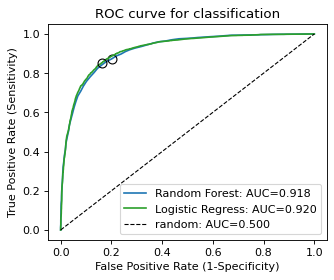

In [9]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

from hilearn import ROC_plot, CrossValidation

LogisticRegression = linear_model.LogisticRegression(solver='lbfgs')
RF_class = RandomForestClassifier(n_estimators=100, n_jobs=-1)

X1 = onehot_array.reshape(-1, 800)
Y1 = df['label'].values

CV = CrossValidation(X1, Y1)
Y1_pre, Y1_score = CV.cv_classification(model=RF_class, folds=10)
Y2_pre, Y2_score = CV.cv_classification(model=LogisticRegression, folds=10)

fig = plt.figure(figsize=(4.5, 3.5), dpi=80)
ROC_plot(Y1, Y1_score[:,1], legend_label="Random Forest", threshold=0.5, base_line=False)
ROC_plot(Y1, Y2_score[:,1], legend_label="Logistic Regress", threshold=0.5)
plt.title("ROC curve for classification")

# fig.savefig("cv_classification.pdf", dpi=300, bbox_inches='tight')
plt.show()

### 1D CNN model

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [11]:
X1 = onehot_array.astype(np.float32)
Y1 = df['label'].values.reshape(-1, 1)
Y1 = np.concatenate([1 - Y1, Y1], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(
    X1, Y1, test_size=0.2,random_state=666,shuffle=True
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=666, shuffle=True
)

In [12]:
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(Tensor(X_train), Tensor(y_train))
valid_data = TensorDataset(Tensor(X_valid), Tensor(y_valid))
test_data  = TensorDataset(Tensor(X_test), Tensor(y_test))

In [13]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=256, shuffle=False)

In [14]:
X_train.shape, len(train_loader.dataset)

((6730, 4, 200), 6730)

#### Model
Set up model with the torch.nn module and train it with nnwrapper which you can find in [../nnwrapper/models/CNN1d.py](../nnwrapper/models/CNN1d.py)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(4, 128, 8),
            nn.ReLU(),
            nn.Conv1d(128, 64, 4),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(3040, 32),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

To install `nnwrapper`: 
- `pip install -U git+https://github.com/huangyh09/nnwrapper`

In [16]:
import nnwrapper
print(nnwrapper.__version__)

0.0.2


In [17]:
from nnwrapper import NNWrapper

model = Net()
# model = nnwrapper.models.CNN1d_base()

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.8)

dev = 'cuda:3' if torch.cuda.is_available() else 'cpu'
my_wrapper = NNWrapper(model, criterion, optimizer, device=dev)
my_wrapper.fit(train_loader, epoch=200, validation_loader=valid_loader, verbose=False)

100%|█████████████████████████████████████████| 200/200 [00:25<00:00,  7.82it/s]


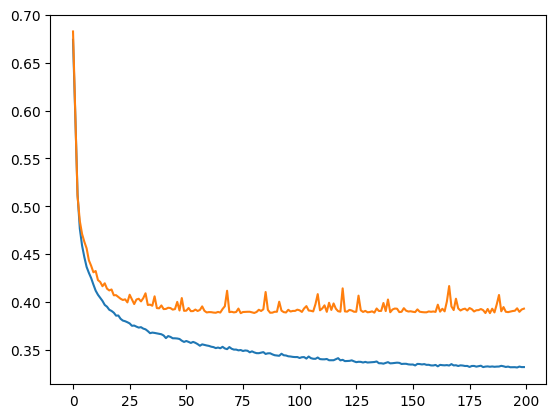

In [18]:
plt.plot(my_wrapper.train_losses)
plt.plot(my_wrapper.valid_losses)

#### More evaluation on test set (you can also try validation set)

In [19]:
y_obs  = torch.cat([y for x, y in test_loader])

y_pred, val_loss = my_wrapper.predict(test_loader)

acc, auc, confu  = nnwrapper.evaluate(y_pred, y_obs)
acc, auc

(0.9135472370766489, 0.9649493028546735)

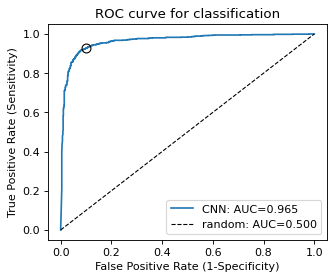

In [20]:
y_scores = y_pred[:, 1].cpu().data.numpy() 
y_obs    = y_obs[:, 1].cpu().data.numpy()

fig = plt.figure(figsize=(4.5, 3.5), dpi=80)
ROC_plot(y_obs, y_scores, legend_label="CNN", threshold=0.5, base_line=True)
plt.title("ROC curve for classification")

# fig.savefig("cv_classification.pdf", dpi=300, bbox_inches='tight')
plt.show()